# 0. Libraries and importing data

## Libraries

In [2]:
import os
import pandas as pd
import numpy as np
from typing import Union
import matplotlib.pyplot as plt
import seaborn as sns

# PanelSplit utilities
from panelsplit.cross_validation import PanelSplit
from panelsplit.application import cross_val_fit_predict  # Fit the estimator using cross-validation and then make predictions

# ML models
from sklearn.ensemble import RandomForestClassifier

# Homework library
from hw1_library import feature_engineering, evaluation

## Importing the data

We import:
1. The target data frames (the ones containing the protest incidence for each state, month and issue from 2017-01 to 2025-04).
2. The aggregated LDA topic share stock for US states from 2017-01 to 2025-03.
3. The aggregated Google Trends data for all of the US states (including dependent territories, like Puerto Rico) from 2015-01 to 2025-05.

In [4]:
# Set the root folder for the clean data
data = 'clean_data/'

In [ ]:
# 1. Import the target data frames

# List all of the .csv in clean_data which begin with incidence_ and end with .csv
inc_healthcare = pd.read_csv(os.path.join(data, 'incidence_healthcare.csv'))
inc_housing = pd.read_csv(os.path.join(data, 'incidence_housing.csv'))
inc_racism = pd.read_csv(os.path.join(data, 'incidence_racism.csv'))  # Topic for racism and immigration
inc_violence = pd.read_csv(os.path.join(data, 'incidence_violence.csv'))  # Topic for guns and criminal justice

# Save all of the target data frames in a dictionary
target_dict = {
    'healthcare': inc_healthcare,
    'housing': inc_housing,
    'racism_and_immigration': inc_racism,
    'guns_and_criminal_justice': inc_violence
}

# Remove the "target" column from the data frames
for key in target_dict.keys():
    target_dict[key] = target_dict[key].drop(columns=['target'])

# Set a multiindex in the target data frames
for key in target_dict.keys():
    target_dict[key] = target_dict[key].set_index(['state', 'period']).sort_index()

# 2. Import the aggregated LDA topic stocks
lda_agg_stock = pd.read_csv(os.path.join(data, 'features', 'lda_shares_us', 'lda_agg_stock.csv'))

# Set the index to be the same as the target data frames
lda_agg_stock = lda_agg_stock.set_index(['state', 'period']).sort_index()

# 3. Import the aggregated Google Trends data
gtrends = pd.read_csv(os.path.join(data, 'features', 'google_trends', 'google_trends_per_state_month.csv'))

# Change the format of the month column to be YYYYMM, as a string
gtrends['month'] = pd.to_datetime(gtrends['month']).dt.strftime('%Y%m')

# Rename the month column to be period
gtrends = gtrends.rename(columns={'month': 'period'})

# Set the index to be the same as the target data frames
gtrends = gtrends.set_index(['state', 'period']).sort_index()

In [33]:
# Display all target data frames
for key in target_dict.keys():
    print(f"Target data frame for {key}:")
    display(target_dict[key].head())
    print("\n")

Target data frame for healthcare:


anytarget_th0  inc_anytarget_th0_h6
state period                                     
AK    201701              0                   1.0
      201702              1                   1.0
      201703              0                   1.0
      201704              0                   1.0
      201705              0                   1.0



Target data frame for housing:


anytarget_th0  inc_anytarget_th0_h6
state period                                     
AK    201701              0                   0.0
      201702              0                   0.0
      201703              0                   0.0
      201704              0                   0.0
      201705              0                   1.0



Target data frame for racism_and_immigration:


anytarget_th0  inc_anytarget_th0_h6
state period                                     
AK    201701              1                   0.0
      201702              0                   1.0
      201703              0                   1.0
      201704              0                   1.0
      201705              0                   1.0



Target data frame for guns_and_criminal_justice:


anytarget_th0  inc_anytarget_th0_h6
state period                                     
AK    201701              0                   1.0
      201702              0                   1.0
      201703              0                   1.0
      201704              0                   1.0
      201705              0                   1.0

In [34]:
print('Data frame for LDA aggregated stocks:')
display(lda_agg_stock.head())
print("\n")

print('Data frame for Google Trends:') 
display(gtrends.head())
print("\n")

Data frame for LDA aggregated stocks:


tokens  article_count  token_stock  stock_pr_topic_0  \
state period                                                         
AK    201701  2226.0             13    2226.0000          0.051113   
      201702  3876.0             18    5656.8000          0.168834   
      201703  5125.0             20    9650.4400          0.143892   
      201704  6214.0             22   13934.3520          0.100407   
      201705  5464.0             28   16611.4816          0.079710   

              stock_pr_topic_1  stock_pr_topic_2  stock_pr_topic_3  \
state period                                                         
AK    201701          0.097180          0.029021          0.051774   
      201702          0.048007          0.044735          0.041778   
      201703          0.046347          0.028465          0.027687   
      201704          0.057656          0.020909          0.024063   
      201705          0.050291          0.017649          0.024871   

              stock_pr_topic_4  stock_pr_topic_5  stock_pr_topic_6  \
state period                                                         
AK    201701          0.105650          0.069980          0.048580   
      201702          0.050353          0.060056          0.083743   
      201703          0.072717          0.055062          0.116458   
      201704          0.067274          0.078466          0.122143   
      201705          0.081926          0.064973          0.167928   

              stock_pr_topic_7  stock_pr_topic_8  stock_pr_topic_9  \
state period                                                         
AK    201701          0.164622          0.019698          0.017215   
      201702          0.159661          0.008003          0.006701   
      201703          0.159897          0.005196          0.005761   
      201704          0.113848          0.005452          0.004213   
      201705          0.094136          0.009029          0.004802   

              stock_pr_topic_10  stock_pr_topic_11  stock_pr_topic_12  \
state period                                                            
AK    201701           0.061863           0.009229           0.161179   
      201702           0.042831           0.018224           0.216510   
      201703           0.054533           0.010443           0.225568   
      201704           0.065199           0.008170           0.281887   
      201705           0.048415           0.008420           0.231442   

              stock_pr_topic_13  stock_pr_topic_14  
state period                                        
AK    201701           0.013923           0.098973  
      201702           0.015655           0.034910  
      201703           0.012891           0.035084  
      201704           0.026225           0.024089  
      201705           0.055474           0.060935



Data frame for Google Trends:


criminal justice  health  healthcare  immigrants  rent
state period                                                        
AK    201501                53      71          40        22.0    62
      201502                 0      77          50         0.0    62
      201503                55      75          47         0.0    66
      201504                 0      76          40        26.0    66
      201505                 0      59          33         0.0    66

## Basic EDA

In [15]:
# Check for missing values
for key in target_dict.keys():
    print(f"Missing values in target data frame for {key}:")
    print(target_dict[key].isnull().sum())
    print("\n")

print('Missing values in LDA aggregated stocks:')
print(lda_agg_stock.isnull().sum())
print("\n")

print('Missing values in Google Trends:')
print(gtrends.isnull().sum())
print("\n")

Missing values in target data frame for healthcare:
anytarget_th0             0
inc_anytarget_th0_h6    336
dtype: int64


Missing values in target data frame for housing:
anytarget_th0             0
inc_anytarget_th0_h6    336
dtype: int64


Missing values in target data frame for racism_and_immigration:
anytarget_th0             0
inc_anytarget_th0_h6    336
dtype: int64


Missing values in target data frame for guns_and_criminal_justice:
anytarget_th0             0
inc_anytarget_th0_h6    336
dtype: int64


Missing values in LDA aggregated stocks:
tokens               0
article_count        0
token_stock          0
stock_pr_topic_0     0
stock_pr_topic_1     0
stock_pr_topic_2     0
stock_pr_topic_3     0
stock_pr_topic_4     0
stock_pr_topic_5     0
stock_pr_topic_6     0
stock_pr_topic_7     0
stock_pr_topic_8     0
stock_pr_topic_9     0
stock_pr_topic_10    0
stock_pr_topic_11    0
stock_pr_topic_12    0
stock_pr_topic_13    0
stock_pr_topic_14    0
dtype: int64


Missing values

Explanation of the missing values:
- Target data frames: the missing values correspond to the last 6 periods for which we have data (from 2024-11 to 2025-04). As the future is not known (2025-05 is not complete), incidence cannot be computed, which leaves 6 (periods) times 56 (states) = 336 missing values per target data frame.
- Google Trends data: the missing values correspond to the fact that American Samoa did not have enough searches for *immigrants* in the period analyzed. 

In [38]:
# Check the shape of the data frames
for key in target_dict.keys():
    print(f"Shape of target data frame for {key}:")
    print(target_dict[key].shape)
    print("\n")

print('Shape of LDA aggregated stocks:')
print(lda_agg_stock.shape)
print("\n")

print('Shape of Google Trends:')
print(gtrends.shape)
print("\n")

Shape of target data frame for healthcare:
(5600, 2)


Shape of target data frame for housing:
(5600, 2)


Shape of target data frame for racism_and_immigration:
(5600, 2)


Shape of target data frame for guns_and_criminal_justice:
(5600, 2)


Shape of LDA aggregated stocks:
(5293, 18)


Shape of Google Trends:
(7000, 5)




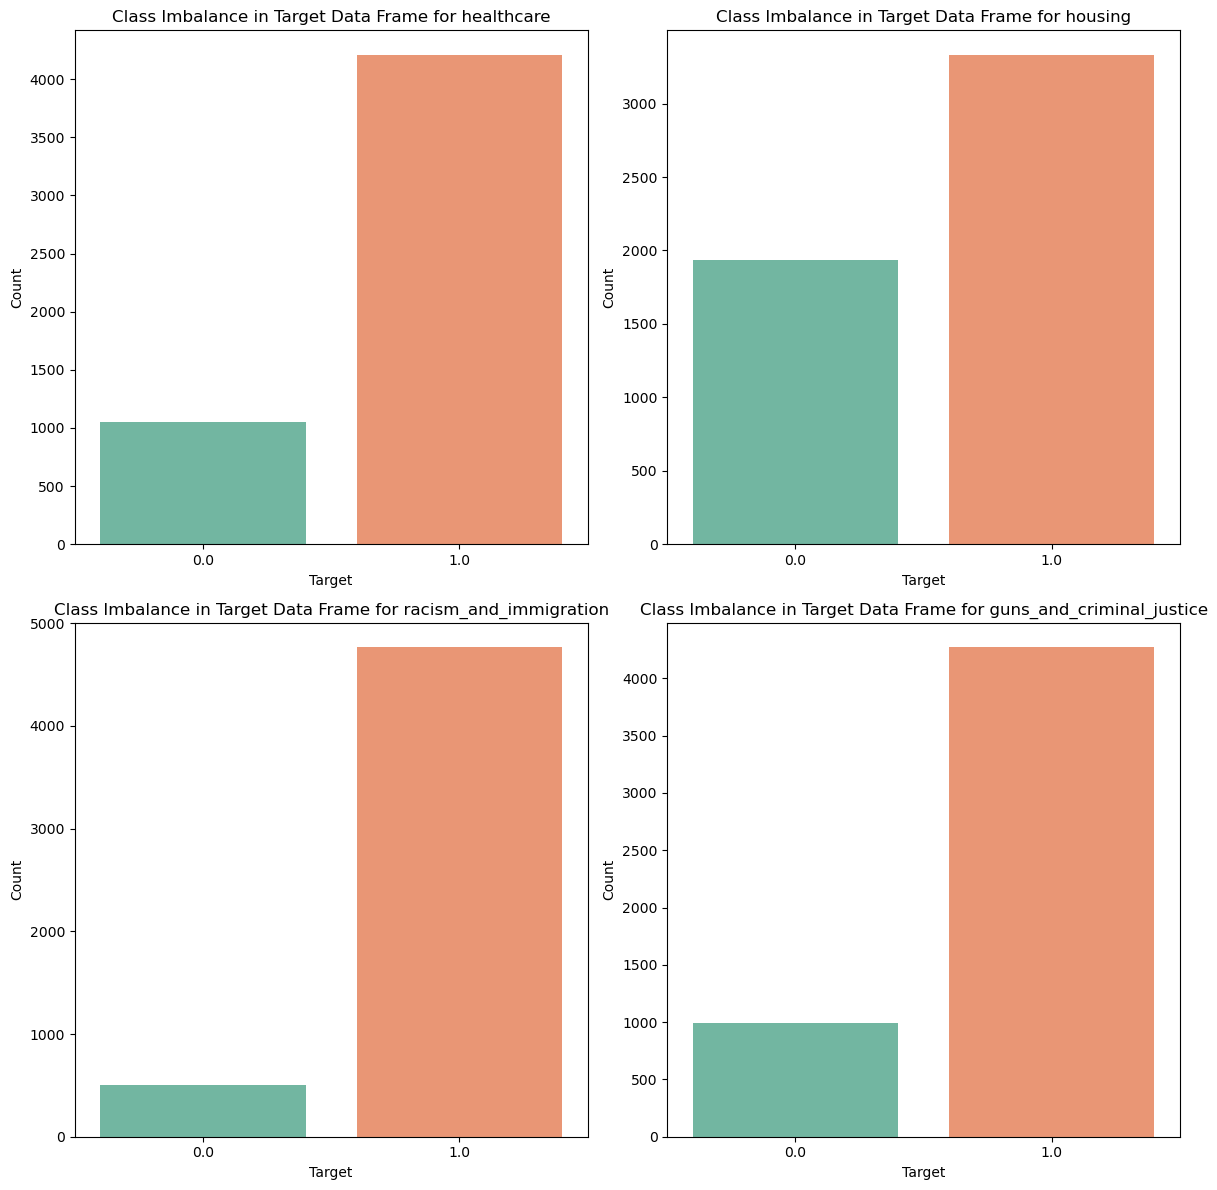

In [ ]:
# Plot class imbalance for the target data frames

# Create a figure with 2 subplots per row and number of keys / 2 rows
num_keys = len(target_dict.keys())
num_rows = (num_keys + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
fig.subplots_adjust(hspace=0.4)

# Create a count plot for each target data frame
for i, key in enumerate(target_dict.keys()):
    ax = axes[i // 2, i % 2]  # Get the correct subplot
    sns.countplot(x='inc_anytarget_th0_h6', data=target_dict[key], palette='Set2', hue='inc_anytarget_th0_h6', ax=ax, legend=False)
    ax.set_title(f'Class Imbalance in Target Data Frame for {key}')
    ax.set_xlabel('Target')
    ax.set_ylabel('Count')
    plt.tight_layout()
plt.show()

# 1. Pipeline description

In other notebooks we have already created:
- `creating_incidence.ipynb`: the target variable (incidence of protests of certain issues - healthcare, housing, guns and criminal justice and racism and immigration).
- `aggregating_US_LDA_shares.ipynb`: the stock for LDA topic shares per month and US state.
- `aggregating_google_trends.ipynb`: Google Trends index per each month and US state, for the following terms:
  - *health* and *healthcare* (for the issue of *healthcare*).
  - *criminal justice* (for the issue of *guns and criminal justice*).
  - *rent* (for the issue of *housing*).
  - *immigrants* (for the issue of *immigration of racism*).

With the output from these notebooks as a starting point, in this notebook we make predictions for the incidence of violent protests related to certain issues, and evaluate the results with the precision-recall and ROC curves.

# 2. Feature engineering

As all of the features engineered in the class below only incorporate past data into the computation (and not future data), we can safely implement them without having to split the target data frame into as many data frames as train-test splits and then creating the features for each data frame.

Set of features that are used or created below:
1. Rolling weighted mean of the number of protests per issue for window sizes 1, 3 and 12.
2. Number of months since the number of protests related to a certain issue exceeed *x* (since).
3. Periods of consecutive months exceeding *x* (ongoing).
4. LDA stock topics.
5. Google Trends index for some keywords related to the protest issues.

In [37]:
# Initialize the FeatureEngineer class and set groupby columns to the state level
feature_engineer = feature_engineering.FeatureEngineer(groupby_cols = 'state')

## Weighted rolling mean

In [ ]:
# 1. Rolling weighted mean of fatalities for window sizes of [1, 3, 12, 36, 60]

df = feature_engineer.weighted_rolling_mean(
    input_df = df_target,
    y_col = 'violence',  # Create weighted rolling variables with number of fatalities
    windows = [1, 3, 12, 36, 60],  # Window sizes (number of periods to consider for the rolling mean)
    closed = None,  # Include current period in the computation of the rolling mean
    return_logs = False,  # Do not return logs
    alpha = 0.8  # Decay factor for weights (higher alpha -> relevance of values more evenly distributed from the past and present periods)
)

# Show results
display(df.head())  # Display the first few rows of the DataFrame with the new features
display(df.tail())  # Display the last few rows of the DataFrame with the new features

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     201001       344                1                      1.0   
        201002       536                1                      1.0   
        201003       407                1                      1.0   
        201004       503                1                      1.0   
        201005       502                1                      1.0   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
AFG     201001                      NaN                            344.0   
        201002                      NaN                            536.0   
        201003                      NaN                            407.0   
        201004                      NaN                            503.0   
        201005                      NaN                            502.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
AFG     201001                       344.000000   
        201002                       225.333333   
        201003                       144.256831   
        201004                       160.060109   
        201005                       159.136612   

                violence_weighted_rolling_mean12  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean36  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean60  
isocode period                                    
AFG     201001                        344.000000  
        201002                        225.333333  
        201003                        144.256831  
        201004                        114.140244  
        201005                         94.015612

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
ZWE     202408         0                0                      NaN   
        202409         0                0                      NaN   
        202410         0                0                      NaN   
        202411         0                0                      NaN   
        202412         0                0                      NaN   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
ZWE     202408                      NaN                              0.0   
        202409                      NaN                              0.0   
        202410                      NaN                              0.0   
        202411                      NaN                              0.0   
        202412                      NaN                              0.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
ZWE     202408                              0.0   
        202409                              0.0   
        202410                              0.0   
        202411                              0.0   
        202412                              0.0   

                violence_weighted_rolling_mean12  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean36  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean60  
isocode period                                    
ZWE     202408                      2.187646e-07  
        202409                      1.750117e-07  
        202410                      1.349010e-07  
        202411                      1.079208e-07  
        202412                      7.611999e-08

Note that, the higher the time window, the more we will consider a country's violent history.

In [ ]:
# 1. Rolling weighted mean of fatalities for window sizes of [1, 3, 12, 36, 60]

windows = [1, 3, 12]  # Window sizes (number of periods to consider for the rolling mean)

# Create the feature for every data frame
for key in target_dict.keys():
    df_target = target_dict[key]  # Get the target data frame
    df_target = feature_engineer.weighted_rolling_mean(
        input_df = df_target,
        y_col = 'violence',  # Create weighted rolling variables with number of fatalities
        windows = windows,  # Window sizes (number of periods to consider for the rolling mean)
        closed = None,  # Include current period in the computation of the rolling mean
        return_logs = False,  # Do not return logs
        alpha = 0.8  # Decay factor for weights (higher alpha -> relevance of values more evenly distributed from the past and present periods)
    )
    target_dict[key] = df_target  # Update the target data frame in the dictionary

# Show results for the healthcare data frame
display(inc_healthcare.head())  # Display the first few rows of the DataFrame with the new features
display(inc_healthcare.tail())  # Display the last few rows of the DataFrame with the new features

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     201001       344                1                      1.0   
        201002       536                1                      1.0   
        201003       407                1                      1.0   
        201004       503                1                      1.0   
        201005       502                1                      1.0   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
AFG     201001                      NaN                            344.0   
        201002                      NaN                            536.0   
        201003                      NaN                            407.0   
        201004                      NaN                            503.0   
        201005                      NaN                            502.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
AFG     201001                       344.000000   
        201002                       225.333333   
        201003                       144.256831   
        201004                       160.060109   
        201005                       159.136612   

                violence_weighted_rolling_mean12  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean36  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean60  
isocode period                                    
AFG     201001                        344.000000  
        201002                        225.333333  
        201003                        144.256831  
        201004                        114.140244  
        201005                         94.015612

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
ZWE     202408         0                0                      NaN   
        202409         0                0                      NaN   
        202410         0                0                      NaN   
        202411         0                0                      NaN   
        202412         0                0                      NaN   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
ZWE     202408                      NaN                              0.0   
        202409                      NaN                              0.0   
        202410                      NaN                              0.0   
        202411                      NaN                              0.0   
        202412                      NaN                              0.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
ZWE     202408                              0.0   
        202409                              0.0   
        202410                              0.0   
        202411                              0.0   
        202412                              0.0   

                violence_weighted_rolling_mean12  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean36  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean60  
isocode period                                    
ZWE     202408                      2.187646e-07  
        202409                      1.750117e-07  
        202410                      1.349010e-07  
        202411                      1.079208e-07  
        202412                      7.611999e-08

## Since

In [ ]:
# 2. Number of months since violence exceeed 0 fatalities
df_since = feature_engineer.since(
    input_df = df,
    y_col = 'violence',  # Create since variables with number of fatalities
    thresholds = [0, 5, 100],  # Thresholds to count since (0 fatalities, 5 fatalities, 100 fatalities)
    shift_knowledge = None  # No shift knowledge set (number of periods to shift the count since variable) -> assumes we know the y_col in current period
)

# Merge the since variables with the original target DataFrame
df = pd.merge(
    df,
    df_since,
    on = ['state', 'period'],  # Merge on the multiindex columns
    how = 'outer',  # Outer join to keep all rows
    suffixes=(None, '_y')  # Suffixes for overlapping column names
) 
# Drop the columns suffixed with '_y' that are not needed (as they are the same as the original columns)
df = df.loc[:, ~df.columns.str.endswith('_y')]

# Show results
display(df.head())  # Display the first few rows of the DataFrame with the new features
display(df.tail())  # Display the last few rows of the DataFrame with the new features

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     201001       344                1                      1.0   
        201002       536                1                      1.0   
        201003       407                1                      1.0   
        201004       503                1                      1.0   
        201005       502                1                      1.0   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
AFG     201001                      NaN                            344.0   
        201002                      NaN                            536.0   
        201003                      NaN                            407.0   
        201004                      NaN                            503.0   
        201005                      NaN                            502.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
AFG     201001                       344.000000   
        201002                       225.333333   
        201003                       144.256831   
        201004                       160.060109   
        201005                       159.136612   

                violence_weighted_rolling_mean12  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean36  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean60  violence_since_0  \
isocode period                                                       
AFG     201001                        344.000000                 0   
        201002                        225.333333                 0   
        201003                        144.256831                 0   
        201004                        114.140244                 0   
        201005                         94.015612                 0   

                violence_since_5  violence_since_100  
isocode period                                        
AFG     201001                 0                   0  
        201002                 0                   0  
        201003                 0                   0  
        201004                 0                   0  
        201005                 0                   0

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
ZWE     202408         0                0                      NaN   
        202409         0                0                      NaN   
        202410         0                0                      NaN   
        202411         0                0                      NaN   
        202412         0                0                      NaN   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
ZWE     202408                      NaN                              0.0   
        202409                      NaN                              0.0   
        202410                      NaN                              0.0   
        202411                      NaN                              0.0   
        202412                      NaN                              0.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
ZWE     202408                              0.0   
        202409                              0.0   
        202410                              0.0   
        202411                              0.0   
        202412                              0.0   

                violence_weighted_rolling_mean12  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean36  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean60  violence_since_0  \
isocode period                                                       
ZWE     202408                      2.187646e-07                47   
        202409                      1.750117e-07                48   
        202410                      1.349010e-07                49   
        202411                      1.079208e-07                50   
        202412                      7.611999e-08                51   

                violence_since_5  violence_since_100  
isocode period                                        
ZWE     202408               176                 176  
        202409               177                 177  
        202410               178                 178  
        202411               179                 179  
        202412               180                 180

In [ ]:
# 2. Number of months since violence exceeed 0 fatalities

thresholds = [0, 5, 100]  # Thresholds of protests to count since

# Create the feature for every data frame
for key in target_dict.keys():
    df_target = target_dict[key]  # Get the target data frame
    df_since = feature_engineer.since(
        input_df = df_target,
        y_col = 'violence',  # Create since variables with number of fatalities
        thresholds = thresholds,  # Thresholds to count since (0 fatalities, 5 fatalities, 100 fatalities)
        shift_knowledge = None  # No shift knowledge set (number of periods to shift the count since variable) -> assumes we know the y_col in current period
    )
    # Merge the since variables with the original target DataFrame
    target_dict[key] = pd.merge(
        df_target,
        df_since,
        on = ['state', 'period'],  # Merge on the multiindex columns
        how = 'outer',  # Outer join to keep all rows
        suffixes=(None, '_y')  # Suffixes for overlapping column names
    )
    # Drop the columns suffixed with '_y' that are not needed (as they are the same as the original columns) 
    target_dict[key] = target_dict[key].loc[:, ~target_dict[key].columns.str.endswith('_y')]  

df_since = feature_engineer.since(
    input_df = df,
    y_col = 'violence',  # Create since variables with number of fatalities
    thresholds = [0, 5, 100],  # Thresholds to count since (0 fatalities, 5 fatalities, 100 fatalities)
    shift_knowledge = None  # No shift knowledge set (number of periods to shift the count since variable) -> assumes we know the y_col in current period
)

# Merge the since variables with the original target DataFrame
df = pd.merge(
    df,
    df_since,
    on = ['state', 'period'],  # Merge on the multiindex columns
    how = 'outer',  # Outer join to keep all rows
    suffixes=(None, '_y')  # Suffixes for overlapping column names
) 
# Drop the columns suffixed with '_y' that are not needed (as they are the same as the original columns)
df = df.loc[:, ~df.columns.str.endswith('_y')]

# Show results
display(df.head())  # Display the first few rows of the DataFrame with the new features
display(df.tail())  # Display the last few rows of the DataFrame with the new features

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     201001       344                1                      1.0   
        201002       536                1                      1.0   
        201003       407                1                      1.0   
        201004       503                1                      1.0   
        201005       502                1                      1.0   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
AFG     201001                      NaN                            344.0   
        201002                      NaN                            536.0   
        201003                      NaN                            407.0   
        201004                      NaN                            503.0   
        201005                      NaN                            502.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
AFG     201001                       344.000000   
        201002                       225.333333   
        201003                       144.256831   
        201004                       160.060109   
        201005                       159.136612   

                violence_weighted_rolling_mean12  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean36  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean60  violence_since_0  \
isocode period                                                       
AFG     201001                        344.000000                 0   
        201002                        225.333333                 0   
        201003                        144.256831                 0   
        201004                        114.140244                 0   
        201005                         94.015612                 0   

                violence_since_5  violence_since_100  
isocode period                                        
AFG     201001                 0                   0  
        201002                 0                   0  
        201003                 0                   0  
        201004                 0                   0  
        201005                 0                   0

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
ZWE     202408         0                0                      NaN   
        202409         0                0                      NaN   
        202410         0                0                      NaN   
        202411         0                0                      NaN   
        202412         0                0                      NaN   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
ZWE     202408                      NaN                              0.0   
        202409                      NaN                              0.0   
        202410                      NaN                              0.0   
        202411                      NaN                              0.0   
        202412                      NaN                              0.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
ZWE     202408                              0.0   
        202409                              0.0   
        202410                              0.0   
        202411                              0.0   
        202412                              0.0   

                violence_weighted_rolling_mean12  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean36  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean60  violence_since_0  \
isocode period                                                       
ZWE     202408                      2.187646e-07                47   
        202409                      1.750117e-07                48   
        202410                      1.349010e-07                49   
        202411                      1.079208e-07                50   
        202412                      7.611999e-08                51   

                violence_since_5  violence_since_100  
isocode period                                        
ZWE     202408               176                 176  
        202409               177                 177  
        202410               178                 178  
        202411               179                 179  
        202412               180                 180

## Ongoing

In [ ]:
# 3. Periods of consecutive months exceeding 0 fatalities (ongoing)
df_ongoing = feature_engineer.ongoing(
    input_df = df,
    y_col = 'violence',  # Create since variables with number of fatalities
    thresholds = [0, 5, 100],  # Thresholds to count since (0 fatalities, 5 fatalities, 100 fatalities)
    shift_knowledge = None  # No shift knowledge set (number of periods to shift the count since variable) -> assumes we know the y_col in current period
)

# Merge the since variables with the original target DataFrame
df = pd.merge(
    df,
    df_ongoing,
    on = ['state', 'period'],  # Merge on the multiindex columns
    how = 'outer',  # Outer join to keep all rows
    suffixes=(None, '_y')  # Suffixes for overlapping column names
) 
# Drop the columns suffixed with '_y' that are not needed (as they are the same as the original columns)
df = df.loc[:, ~df.columns.str.endswith('_y')]

# Show results
display(df.head())  # Display the first few rows of the DataFrame with the new features
display(df.tail())  # Display the last few rows of the DataFrame with the new features

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     201001       344                1                      1.0   
        201002       536                1                      1.0   
        201003       407                1                      1.0   
        201004       503                1                      1.0   
        201005       502                1                      1.0   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
AFG     201001                      NaN                            344.0   
        201002                      NaN                            536.0   
        201003                      NaN                            407.0   
        201004                      NaN                            503.0   
        201005                      NaN                            502.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
AFG     201001                       344.000000   
        201002                       225.333333   
        201003                       144.256831   
        201004                       160.060109   
        201005                       159.136612   

                violence_weighted_rolling_mean12  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean36  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean60  violence_since_0  \
isocode period                                                       
AFG     201001                        344.000000                 0   
        201002                        225.333333                 0   
        201003                        144.256831                 0   
        201004                        114.140244                 0   
        201005                         94.015612                 0   

                violence_since_5  violence_since_100  violence_ongoing_0  \
isocode period                                                             
AFG     201001                 0                   0                   1   
        201002                 0                   0                   2   
        201003                 0                   0                   3   
        201004                 0                   0                   4   
        201005                 0                   0                   5   

                violence_ongoing_5  violence_ongoing_100  
isocode period                                            
AFG     201001                   1                     1  
        201002                   2                     2  
        201003                   3                     3  
        201004                   4                     4  
        201005                   5                     5

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
ZWE     202408         0                0                      NaN   
        202409         0                0                      NaN   
        202410         0                0                      NaN   
        202411         0                0                      NaN   
        202412         0                0                      NaN   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
ZWE     202408                      NaN                              0.0   
        202409                      NaN                              0.0   
        202410                      NaN                              0.0   
        202411                      NaN                              0.0   
        202412                      NaN                              0.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
ZWE     202408                              0.0   
        202409                              0.0   
        202410                              0.0   
        202411                              0.0   
        202412                              0.0   

                violence_weighted_rolling_mean12  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean36  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean60  violence_since_0  \
isocode period                                                       
ZWE     202408                      2.187646e-07                47   
        202409                      1.750117e-07                48   
        202410                      1.349010e-07                49   
        202411                      1.079208e-07                50   
        202412                      7.611999e-08                51   

                violence_since_5  violence_since_100  violence_ongoing_0  \
isocode period                                                             
ZWE     202408               176                 176                   0   
        202409               177                 177                   0   
        202410               178                 178                   0   
        202411               179                 179                   0   
        202412               180                 180                   0   

                violence_ongoing_5  violence_ongoing_100  
isocode period                                            
ZWE     202408                   0                     0  
        202409                   0                     0  
        202410                   0                     0  
        202411                   0                     0  
        202412                   0                     0

## Lags

In [ ]:
# Create lags of the violence variable (for 1, 2 and 3 periods)
df = feature_engineer.lag(
    input_df = df,
    y_col = 'violence',  # Create lagged variables with number of fatalities
    lags = [1, 2, 3]  # Lag values to create
)

# Show results
display(df.head())  # Display the first few rows of the DataFrame with the new features
display(df.tail())  # Display the last few rows of the DataFrame with the new features

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     201001       344                1                      1.0   
        201002       536                1                      1.0   
        201003       407                1                      1.0   
        201004       503                1                      1.0   
        201005       502                1                      1.0   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
AFG     201001                      NaN                            344.0   
        201002                      NaN                            536.0   
        201003                      NaN                            407.0   
        201004                      NaN                            503.0   
        201005                      NaN                            502.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
AFG     201001                       344.000000   
        201002                       225.333333   
        201003                       144.256831   
        201004                       160.060109   
        201005                       159.136612   

                violence_weighted_rolling_mean12  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean36  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean60  violence_since_0  ...  \
isocode period                                                      ...   
AFG     201001                        344.000000                 0  ...   
        201002                        225.333333                 0  ...   
        201003                        144.256831                 0  ...   
        201004                        114.140244                 0  ...   
        201005                         94.015612                 0  ...   

                stock_topic_10  stock_topic_11  stock_topic_12  \
isocode period                                                   
AFG     201001        0.022914        0.036579        0.088708   
        201002        0.021915        0.038197        0.093011   
        201003        0.021165        0.039799        0.093782   
        201004        0.021542        0.040595        0.094116   
        201005        0.022203        0.040729        0.098276   

                stock_topic_13  stock_topic_14   tokens   stock_tokens  \
isocode period                                                           
AFG     201001        0.060646        0.208263  46266.0  223668.448646   
        201002        0.061759        0.208764  45909.0  224843.758917   
        201003        0.066846        0.216333  43505.0  223380.007134   
        201004        0.066496        0.211046  26844.0  205548.005707   
        201005        0.067144        0.206317  29560.0  193998.404565   

                violence_basic_lag1  violence_basic_lag2  violence_basic_lag3  
isocode period                                                                 
AFG     201001                  NaN                  NaN                  NaN  
        201002                344.0                  NaN                  NaN  
        201003                536.0                344.0                  Na

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
ZWE     202408         0                0                      NaN   
        202409         0                0                      NaN   
        202410         0                0                      NaN   
        202411         0                0                      NaN   
        202412         0                0                      NaN   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
ZWE     202408                      NaN                              0.0   
        202409                      NaN                              0.0   
        202410                      NaN                              0.0   
        202411                      NaN                              0.0   
        202412                      NaN                              0.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
ZWE     202408                              0.0   
        202409                              0.0   
        202410                              0.0   
        202411                              0.0   
        202412                              0.0   

                violence_weighted_rolling_mean12  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean36  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean60  violence_since_0  ...  \
isocode period                                                      ...   
ZWE     202408                      2.187646e-07                47  ...   
        202409                      1.750117e-07                48  ...   
        202410                      1.349010e-07                49  ...   
        202411                      1.079208e-07                50  ...   
        202412                      7.611999e-08                51  ...   

                stock_topic_10  stock_topic_11  stock_topic_12  \
isocode period                                                   
ZWE     202408        0.063931        0.041425        0.168542   
        202409        0.059979        0.044317        0.163661   
        202410        0.064546        0.042793        0.154535   
        202411        0.065903        0.049195        0.154616   
        202412        0.074427        0.043318        0.187599   

                stock_topic_13  stock_topic_14  tokens  stock_tokens  \
isocode period                                                         
ZWE     202408        0.034418        0.041159  1179.0   6422.882863   
        202409        0.032918        0.042444   495.0   5633.306290   
        202410        0.033111        0.042961   286.0   4792.645032   
        202411        0.034479        0.035031   976.0   4810.116026   
        202412        0.027490        0.027630  1518.0   5366.092821   

                violence_basic_lag1  violence_basic_lag2  violence_basic_lag3  
isocode period                                                                 
ZWE     202408                  0.0                  0.0                  0.0  
        202409                  0.0                  0.0                  0.0  
        202410                  0.0                  0.0                  0.0  
        20

## LDA stock topics

In [ ]:
# 4. LDA stock topics: merge the stock topics into the previous data frame
df = pd.merge(
    df,
    topics,
    on = ['state', 'period'],  # Merge on the multiindex columns
    how = 'outer',  # Outer join to keep all rows
    suffixes=(None, '_y')  # Suffixes for overlapping column names
)

# Show results
display(df.head())  # Display the first few rows of the DataFrame with the new features
display(df.tail())  # Display the last few rows of the DataFrame with the new features

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     201001       344                1                      1.0   
        201002       536                1                      1.0   
        201003       407                1                      1.0   
        201004       503                1                      1.0   
        201005       502                1                      1.0   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
AFG     201001                      NaN                            344.0   
        201002                      NaN                            536.0   
        201003                      NaN                            407.0   
        201004                      NaN                            503.0   
        201005                      NaN                            502.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
AFG     201001                       344.000000   
        201002                       225.333333   
        201003                       144.256831   
        201004                       160.060109   
        201005                       159.136612   

                violence_weighted_rolling_mean12  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean36  \
isocode period                                     
AFG     201001                        344.000000   
        201002                        225.333333   
        201003                        144.256831   
        201004                        114.140244   
        201005                         94.015612   

                violence_weighted_rolling_mean60  violence_since_0  ...  \
isocode period                                                      ...   
AFG     201001                        344.000000                 0  ...   
        201002                        225.333333                 0  ...   
        201003                        144.256831                 0  ...   
        201004                        114.140244                 0  ...   
        201005                         94.015612                 0  ...   

                stock_topic_7  stock_topic_8  stock_topic_9  stock_topic_10  \
isocode period                                                                
AFG     201001       0.052580       0.019800       0.004761        0.022914   
        201002       0.049715       0.021267       0.004845        0.021915   
        201003       0.051960       0.025952       0.004937        0.021165   
        201004       0.052503       0.025788       0.004879        0.021542   
        201005       0.051360       0.025376       0.004617        0.022203   

                stock_topic_11  stock_topic_12  stock_topic_13  \
isocode period                                                   
AFG     201001        0.036579        0.088708        0.060646   
        201002        0.038197        0.093011        0.061759   
        201003        0.039799        0.093782        0.066846   
        201004        0.040595        0.094116        0.066496   
        201005        0.040729        0.098276        0.067144   

                stock_topic_14   tokens   stock_tokens  
isocode period                                          
AFG     201001        0.208263  46266.0  223668.448646  
        201002        0.208764  45909.0  224843.758917  
        201003        0.216333  43505.0  223380.007134  
        201004        0.211046  26844.0  205548.005707  
        201005     

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
ZWE     202408         0                0                      NaN   
        202409         0                0                      NaN   
        202410         0                0                      NaN   
        202411         0                0                      NaN   
        202412         0                0                      NaN   

                ons_anyviolence_th0_h12  violence_weighted_rolling_mean1  \
isocode period                                                             
ZWE     202408                      NaN                              0.0   
        202409                      NaN                              0.0   
        202410                      NaN                              0.0   
        202411                      NaN                              0.0   
        202412                      NaN                              0.0   

                violence_weighted_rolling_mean3  \
isocode period                                    
ZWE     202408                              0.0   
        202409                              0.0   
        202410                              0.0   
        202411                              0.0   
        202412                              0.0   

                violence_weighted_rolling_mean12  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean36  \
isocode period                                     
ZWE     202408                               0.0   
        202409                               0.0   
        202410                               0.0   
        202411                               0.0   
        202412                               0.0   

                violence_weighted_rolling_mean60  violence_since_0  ...  \
isocode period                                                      ...   
ZWE     202408                      2.187646e-07                47  ...   
        202409                      1.750117e-07                48  ...   
        202410                      1.349010e-07                49  ...   
        202411                      1.079208e-07                50  ...   
        202412                      7.611999e-08                51  ...   

                stock_topic_7  stock_topic_8  stock_topic_9  stock_topic_10  \
isocode period                                                                
ZWE     202408       0.125278       0.013097       0.005083        0.063931   
        202409       0.130381       0.013105       0.005576        0.059979   
        202410       0.129117       0.013185       0.005885        0.064546   
        202411       0.133439       0.014436       0.005477        0.065903   
        202412       0.134205       0.014198       0.005177        0.074427   

                stock_topic_11  stock_topic_12  stock_topic_13  \
isocode period                                                   
ZWE     202408        0.041425        0.168542        0.034418   
        202409        0.044317        0.163661        0.032918   
        202410        0.042793        0.154535        0.033111   
        202411        0.049195        0.154616        0.034479   
        202412        0.043318        0.187599        0.027490   

                stock_topic_14  tokens  stock_tokens  
isocode period                                        
ZWE     202408        0.041159  1179.0   6422.882863  
        202409        0.042444   495.0   5633.306290  
        202410        0.042961   286.0   4792.645032  
        202411        0.035031   976.0   4810.116026  
        202412        0.027630 

In [ ]:
df.shape

(31302, 32)

It has the same shape as at the beginning, which is a good thing: there have not been unexpected misalingments.

## Google Trends

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31302 entries, ('AFG', 201001) to ('ZWE', 202412)
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   violence                          31302 non-null  int64  
 1   anyviolence_th0                   31302 non-null  int64  
 2   inc_anyviolence_th0_h12           29214 non-null  float64
 3   ons_anyviolence_th0_h12           23261 non-null  float64
 4   violence_weighted_rolling_mean1   31302 non-null  float64
 5   violence_weighted_rolling_mean3   31302 non-null  float64
 6   violence_weighted_rolling_mean12  31302 non-null  float64
 7   violence_weighted_rolling_mean36  31302 non-null  float64
 8   violence_weighted_rolling_mean60  31302 non-null  float64
 9   violence_since_0                  31302 non-null  int64  
 10  violence_since_5                  31302 non-null  int64  
 11  violence_since_100                31302 non

# 3. Train-test split of the target variable

`panelsplit` library documentation: https://4freye.github.io/panelsplit/panelsplit.html. Explanation of some relevant parameters:
- `n_splits` sets the number of the `TimeSeriesSplit`s scikit-learn's class (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html). The higher the number of splits, the more periods we will use as the validation data. If, for example, test predictions start in 202401 and we want to generate pseudo-out-of-sample predictions for every month (`test_size=1`) up to 202503, we can set the number of splits dynamically to the number of periods between 202401 and 202503, included.
- `test_size` sets the number of observations to predict in each validation split. For example, if it is set to 1, per each split we will be predicting one period (the next one, if the periods are ordered).

In [51]:
# Print the different periods in the merged data frame
df_target.index.get_level_values('period')

Index([201001, 201002, 201003, 201004, 201005, 201006, 201007, 201008, 201009,
       201010,
       ...
       202403, 202404, 202405, 202406, 202407, 202408, 202409, 202410, 202411,
       202412],
      dtype='int64', name='period', length=31302)

In [52]:
# Keep only the periods up to 202412, included
df_target = df_target[df_target.index.get_level_values('period') <= 202412]
df_target.shape

(31302, 4)

In [ ]:
# Number of periods between 202401 onwards
n_test_periods = sum(df_target.index.get_level_values('period').unique() >= 202401)
print(n_test_periods)  # Should be of 2 years (24 months)

24


In [ ]:
# Set the parameters
n_splits = n_test_periods  # Set number of test periods dynamically to requirements
test_size = 1
gap = horizon - 1  # Set gap (horizon - 1), using rule of thumb to avoid data leakage

# Sort the index again to ensure that the periods are in the right order
df_target = df_target.sort_index()

# Perform the train-test split. This returns a list of tuples, where each tuple
# contains the train and test indices for each split
ps = PanelSplit(
    periods = df_target.index.get_level_values('period'),
    unique_periods = None,  # Unique periods will be computed from periods
    n_splits=n_splits,
    test_size=test_size,
    gap=gap
)

# Show the first and second train-test splits
display(ps._u_periods_cv[0:2])

# The list of tuples should be of length 24 (the number of test periods)
print(f'Number of test periods: {len(ps._u_periods_cv)}')

[(array([201001, 201002, 201003, 201004, 201005, 201006, 201007, 201008,
         201009, 201010, 201011, 201012, 201101, 201102, 201103, 201104,
         201105, 201106, 201107, 201108, 201109, 201110, 201111, 201112,
         201201, 201202, 201203, 201204, 201205, 201206, 201207, 201208,
         201209, 201210, 201211, 201212, 201301, 201302, 201303, 201304,
         201305, 201306, 201307, 201308, 201309, 201310, 201311, 201312,
         201401, 201402, 201403, 201404, 201405, 201406, 201407, 201408,
         201409, 201410, 201411, 201412, 201501, 201502, 201503, 201504,
         201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512,
         201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608,
         201609, 201610, 201611, 201612, 201701, 201702, 201703, 201704,
         201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712,
         201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808,
         201809, 201810, 201811, 201812, 201901, 20

Number of test periods: 24


In [55]:
display(df_target.loc[df_target.index.get_level_values('period').isin(ps._u_periods_cv[0][0])]) #subset the target dataframe to the train indices of the first split
display(df_target.loc[df_target.index.get_level_values('period').isin(ps._u_periods_cv[0][1])]) #subset the target dataframe to the test indices of the first split

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     201001       344                1                      1.0   
        201002       536                1                      1.0   
        201003       407                1                      1.0   
        201004       503                1                      1.0   
        201005       502                1                      1.0   
...                  ...              ...                      ...   
ZWE     202109         0                0                      0.0   
        202110         0                0                      0.0   
        202111         0                0                      0.0   
        202112         0                0                      0.0   
        202201         0                0                      0.0   

                ons_anyviolence_th0_h12  
isocode period                           
AFG     201001                      NaN  
        201002                      NaN  
        201003                      NaN  
        201004                      NaN  
        201005                      NaN  
...                                 ...  
ZWE     202109                      0.0  
        202110                      0.0  
        202111                      0.0  
        202112                      0.0  
        202201                      0.0  

[25212 rows x 4 columns]

,,violence,anyviolence_th0,inc_anyviolence_th0_h12,ons_anyviolence_th0_h12
isocode,period,,,,
AFG,202301,54,1,1.0,NaN
AGO,202301,0,0,0.0,0.0
ALB,202301,0,0,0.0,0.0
ARE,202301,0,0,0.0,0.0
ARG,202301,0,0,0.0,0.0
...,...,...,...,...,...
XKX,202301,0,0,0.0,0.0
YEM,202301,97,1,1.0,NaN
ZAF,202301,1,1,1.0,NaN


# 4. Making the predictions

## 4.1. Splitting the data frame into target and features

In [65]:
# Sort the index again to ensure that the periods are in the right order
df = df.sort_index()

In [67]:
X = df[df.columns[4:]]  # Select all columns except the first 4
incidence = df[f'inc_anyviolence_th{threshold}_h{horizon}']
onset = df[f'ons_anyviolence_th{threshold}_h{horizon}']

## 4.2. Making the prediction for incidence

See https://4freye.github.io/panelsplit/panelsplit/application.html#cross_val_fit_predict.

In [68]:
# Initialize the model
rf = RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100, random_state=42)

In [69]:
# Make the predidctions for incidence
preds_inc, fitted_estimators_inc = cross_val_fit_predict(
    estimator= rf, # ML model of choice e.g. RandomForestClassifier()
    X=X, # Your features dataframe (should not include indices)
    y=incidence,  # Your target e.g. target_df[target_col]
    cv=ps,  # Your cross-validation strategy. All you need is your initialized panelsplit object e.g. PanelSplit(periods, n_splits, test_size, ...)
    method='predict_proba',  # 'predict' or 'predict_proba'
    drop_na_in_y=True  # Whether to drop NAs if they are still present in your target variable
)

In [70]:
# Make the predidctions for onset
preds_ons, fitted_estimators_ons = cross_val_fit_predict(
    estimator= rf, # ML model of choice e.g. RandomForestClassifier()
    X=X, # Your features dataframe (should not include indices)
    y=onset,  # Your target e.g. target_df[target_col]
    cv=ps,  # Your cross-validation strategy. All you need is your initialized panelsplit object e.g. PanelSplit(periods, n_splits, test_size, ...)
    method='predict_proba',  # 'predict' or 'predict_proba'
    drop_na_in_y=True  # Whether to drop NAs if they are still present in your target variable
)

In [71]:
print(preds_inc)

[[0.00227271 0.99772729]
 [0.00287101 0.99712899]
 [0.00261784 0.99738216]
 ...
 [0.88308059 0.11691941]
 [0.88296064 0.11703936]
 [0.88682379 0.11317621]]


In [72]:
print(fitted_estimators_inc)

[RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_sampl

In [ ]:
print(df.index.get_level_values('state').nunique())  # Number of unique countries

174


In [74]:
print(len(preds_inc))  # Should be 24 (months) times the number of countries

4176


In [ ]:
print(df.index.get_level_values('state').nunique()  * 24)

4176


We can now get the feature importances with the `feature_importances_` attribute: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_. Ideally, we could compute the mean feature importance across different splits.

In [76]:
# Feature importances for the first prediction
print(fitted_estimators_inc[0].feature_importances_)

[9.72439139e-02 1.09024951e-01 1.57133543e-01 2.47929230e-01
 1.42455504e-01 5.59940709e-02 2.57118403e-02 1.44829004e-03
 4.01459962e-02 6.09637442e-03 1.70570039e-03 9.91568528e-04
 4.74108517e-04 1.93087814e-02 4.63204090e-04 8.41226683e-04
 2.40486027e-04 3.33341199e-04 8.95305057e-04 1.54401944e-03
 1.54637667e-03 1.57810327e-04 2.57320644e-03 8.18796377e-04
 1.49774307e-04 2.50402367e-04 4.54194453e-04 3.24594274e-03
 3.02801377e-02 2.29862646e-02 2.75556387e-02]


## 4.3. Creating the predictions data frame

Now, we create a data frame to collect the predictions across every split, while retaining the `since` columns.

In [77]:
df_target.head()

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     201001       344                1                      1.0   
        201002       536                1                      1.0   
        201003       407                1                      1.0   
        201004       503                1                      1.0   
        201005       502                1                      1.0   

                ons_anyviolence_th0_h12  
isocode period                           
AFG     201001                      NaN  
        201002                      NaN  
        201003                      NaN  
        201004                      NaN  
        201005                      NaN

Below, we create a data frame with the labels of the test data, by using the method `gen_test_labels` (see https://4freye.github.io/panelsplit/panelsplit/cross_validation.html#PanelSplit.gen_test_labels).

In [78]:
final_preds_df = ps.gen_test_labels(
    df_target.merge(right = X[['violence_since_0', 'violence_since_5', 'violence_since_100']], left_index=True, right_index=True, how='left')) #this will generate a dataframe where you can save down your predictions. Retains the since column also.

In [79]:
final_preds_df.head()

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     202301        54                1                      1.0   
        202302        21                1                      1.0   
        202303        47                1                      1.0   
        202304        52                1                      1.0   
        202305        16                1                      1.0   

                ons_anyviolence_th0_h12  violence_since_0  violence_since_5  \
isocode period                                                                
AFG     202301                      NaN                 0                 0   
        202302                      NaN                 0                 0   
        202303                      NaN                 0                 0   
        202304                      NaN                 0                 0   
        202305                      NaN                 0                 0   

                violence_since_100  
isocode period                      
AFG     202301                   1  
        202302                   2  
        202303                   3  
        202304                   4  
        202305                   5

Now, we add the predictions for both incidence and onset.

In [80]:
final_preds_df['preds_inc'] = preds_inc[:, 1]  # We save the predicted probabilities for class 1 for incidence (assumes method is 'predict_proba')
final_preds_df['preds_ons'] = preds_ons[:, 1]  # We save the predicted probabilities for class 1 for onset (assumes method is 'predict_proba')

In [81]:
final_preds_df.head()

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     202301        54                1                      1.0   
        202302        21                1                      1.0   
        202303        47                1                      1.0   
        202304        52                1                      1.0   
        202305        16                1                      1.0   

                ons_anyviolence_th0_h12  violence_since_0  violence_since_5  \
isocode period                                                                
AFG     202301                      NaN                 0                 0   
        202302                      NaN                 0                 0   
        202303                      NaN                 0                 0   
        202304                      NaN                 0                 0   
        202305                      NaN                 0                 0   

                violence_since_100  preds_inc  preds_ons  
isocode period                                            
AFG     202301                   1   0.997727   0.930325  
        202302                   2   0.997129   0.930136  
        202303                   3   0.997382   0.928538  
        202304                   4   0.997082   0.932608  
        202305                   5   0.997273   0.930096

## 4.4. Saving the predictions

In [82]:
file_name = f'my_preds_th{threshold}_h{horizon}.csv'
final_preds_df.to_csv(file_name)  # Save the predictions to a CSV file
print(f"Predictions saved to {file_name}")  # Print a message indicating that the predictions have been saved

Predictions saved to my_preds_th0_h12.csv


# 5. Evaluation

## 5.1. Precision-recall curve

Use `plot_precision_recall`.

## 5.2. ROC

Use `plot_roc`.